In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib as plt
import matplotlib.pyplot as plt

selected_features_labeled  = pd.read_csv("selected_features.csv",sep='\t')

In [ ]:
##

selected_features_labeled.value_counts()
#zero_value_cols = selected_features_labeled.columns[(selected_features_labeled == 0).all()]
#zero_only_cols = selected_features_labeled.columns[(selected_features_labeled.eq(0)).all()]
zero_counts = (selected_features_labeled == 0).sum()

print("Total missing values: ", selected_features_labeled.isnull().sum().sum())
print("Missing values per column: \n", selected_features_labeled.isnull().sum())
print("Columns with all zero values: ", zero_counts)

Total missing values:  0
Missing values per column: 
 SEQN        0
BPQ020      0
DIQ010      0
DID040      0
DIQ220      0
DIQ190A     0
DIQ190B     0
DIQ230      0
DID260      0
DIQ280      0
DIQ300S     0
DIQ300D     0
PAQ180      0
PADACTIV    0
PADDURAT    0
SLD010H     0
LBXAPB      0
LBDINSI     0
LBXGH       0
RIAGENDR    0
RIDAGEMN    0
dtype: int64
Columns with all zero values:  SEQN           0
BPQ020         0
DIQ010         0
DID040      4733
DIQ220      4914
DIQ190A        0
DIQ190B        0
DIQ230      4733
DID260      4765
DIQ280      4785
DIQ300S     4733
DIQ300D     4733
PAQ180         0
PADACTIV       0
PADDURAT       3
SLD010H        0
LBXAPB       349
LBDINSI      372
LBXGH        329
RIAGENDR       0
RIDAGEMN      32
dtype: int64


In [ ]:
zero_counts = (selected_features_labeled == 0).sum()
print("Number of zeros in the selected features:", zero_counts)

#drop columns
selected_features_labeled = selected_features_labeled.drop(columns=[
    'DID040', 'DIQ220', 'DIQ230', 'DID260', 'DIQ280', 'DIQ300S', 'DIQ300D'
], errors='ignore')

cols_to_check = ['LBXAPB', 'LBDINSI', 'LBXGH', 'PADDURAT', 'RIDAGEMN']

# Drop rows where any of the specified columns contain a zero
selected_features_labeled = selected_features_labeled[(selected_features_labeled[cols_to_check] != 0).all(axis=1)]



Number of zeros in the selected features: SEQN           0
BPQ020         0
DIQ010         0
DID040      4733
DIQ220      4914
DIQ190A        0
DIQ190B        0
DIQ230      4733
DID260      4765
DIQ280      4785
DIQ300S     4733
DIQ300D     4733
PAQ180         0
PADACTIV       0
PADDURAT       3
SLD010H        0
LBXAPB       349
LBDINSI      372
LBXGH        329
RIAGENDR       0
RIDAGEMN      32
dtype: int64


In [17]:
#selected_features_labeled

## save cleaned data to a CSV file
def save_cleaned_data(df, data_path="selected_features_final.csv"):
    if not df.empty:
        df.to_csv(data_path, sep='\t', index=False)
    else:
        print("No data to save.")

save_cleaned_data(selected_features_labeled, data_path="selected_features_final.csv")


In [25]:
## preDM filter
def main():
    combined_selected_features = pd.read_csv('selected_features_final.csv', sep='\t')
    preDM_criteria = (combined_selected_features['LBDINSI'] >= 100) | (combined_selected_features['LBXAPB'] >= 110) | (combined_selected_features['LBXGH'] >= 5.5)

    combined_selected_features = preDMCondFilter(combined_selected_features, preDM_criteria)
    return combined_selected_features

def preDMCondFilter(combined_selected_features, preDM_criteria):
    
    #combined_selected_features.columns = combined_selected_features.columns.str.strip()

    combined_selected_features['PreDM'] = preDM_criteria.astype(int)

    combined_selected_features = combined_selected_features.drop(columns=['LBDINSI', 'LBXAPB', 'LBXGH'], errors='ignore')    

    combined_selected_features.to_csv('selected_features_labeled_final.csv', sep='\t', index=False)

    return combined_selected_features
    
if __name__ == "__main__":
    main()

In [26]:
main()

,SEQN,BPQ020,DIQ010,DIQ190A,DIQ190B,PAQ180,PADACTIV,PADDURAT,SLD010H,RIAGENDR,RIDAGEMN,PreDM
0,31132.0,1.0,1.0,1.0,1,2,42.0,40.0,7.0,1.0,842,1
1,31132.0,1.0,1.0,1.0,1,2,19.0,240.0,7.0,1.0,842,1
2,31134.0,1.0,2.0,1.0,1,3,42.0,30.0,7.0,1.0,882,1
3,31148.0,2.0,2.0,2.0,2,2,23.0,60.0,7.0,2.0,194,0
4,31150.0,2.0,2.0,2.0,2,4,43.0,60.0,8.0,1.0,959,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4531,41462.0,2.0,2.0,2.0,2,3,42.0,30.0,8.0,1.0,678,0
4532,41462.0,2.0,2.0,2.0,2,3,20.0,120.0,8.0,1.0,678,0
4533,41462.0,2.0,2.0,2.0,2,3,29.0,10.0,8.0,1.0,678,0
4534,41465.0,2.0,2.0,1.0,1,1,42.0,30.0,6.0,2.0,222,1


In [93]:
## models, common (prepare for model)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
#from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

#import matplotlib as plt
#import matplotlib.pyplot as plt

def prepareData():
    labeled_selected_features = pd.read_csv('selected_features_labeled_final.csv', sep='\t', header=0)

    X_train, X_test, y_train, y_test = encode_and_split(labeled_selected_features)

    X_train_scaled, X_test_scaled = scaleFeatures(X_train, X_test)
 
    #X_resampled, y_resampled = handle_class_imbalance(X_train_scaled, y_train)

    return X_train_scaled, y_train, X_test_scaled, y_test, y_train

def encode_and_split(labeled_selected_features):

    #X = labeled_selected_features[['BPQ020', 'PADDURAT', 'SLD010H', 'RIAGENDR', 'LBXAPB', 'LBDINSI', 'LBXGH']]
    X = labeled_selected_features[['BPQ020', 'DIQ010','DIQ190A','DIQ190B', 'PAQ180', 'PADACTIV', 'PADDURAT', 'SLD010H', 'RIAGENDR', 'RIDAGEMN']]
    Y = labeled_selected_features["PreDM"].copy()
   
    X = X.loc[Y.index]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, train_size=0.7, random_state=42)

    return X_train, X_test, y_train, y_test

def scaleFeatures(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

# oversample the minority class using SMOTE
# avoid overfitting
# improves performance on imbalanced datasets

""" def handle_class_imbalance(X_train_scaled, y_train):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

    return X_resampled, y_resampled """

## decision tree and logistic regression
def main():
    X_train_scaled, X_test, X_test_scaled, y_test, y_train = prepareData()
    #X_train_scaled, y_train, X_test_scaled, y_test, y_train
    dt_accuracy = train_evaluate_model(X_train_scaled, X_test, X_test_scaled, y_test)
    lr_accuracy = train_evaluate_model(X_train_scaled, X_test, X_test_scaled, y_test)
    xgb_boost_accuracy = train_evaluate_model(X_train_scaled, X_test, X_test_scaled, y_test)
    cross_validate(X_train_scaled, y_train)

    return dt_accuracy, lr_accuracy, xgb_boost_accuracy

def train_evaluate_model(X_train_scaled, X_test, X_test_scaled, y_test):

    #decision tree
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_scaled, X_test)

    y_pred_dt = dt_model.predict(X_test_scaled)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")
    print(classification_report(y_test, y_pred_dt))

    #logistic regression
    log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
    log_reg.fit(X_train_scaled, X_test)

    y_pred_log_reg = log_reg.predict(X_test_scaled)

    accuracy_log = accuracy_score(y_test, y_pred_log_reg)
    print(f"Logistic Regression Accuracy: {accuracy_log:.2f}")
    print(classification_report(y_test, y_pred_log_reg))

    #XGBoost
    xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
    xgb_model.fit(X_train_scaled, X_test, verbose=False) #prevent excessive text output

    y_pred_xgb = xgb_model.predict(X_test_scaled)

    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")
    print(classification_report(y_test, y_pred_xgb))

    return accuracy_dt, accuracy_log, accuracy_xgb

## cross validation
def cross_validate(X_train_scaled, y_train):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Decision Tree Cross-Validation
    dt_scores = cross_val_score(DecisionTreeClassifier(random_state=42), X_train_scaled, y_train, cv=kf, scoring='f1')
    print(f"Decision Tree Cross-Validation Scores: {dt_scores}")
    print(f"Decision Tree Mean CV Accuracy: {dt_scores.mean():.2f}")

    # Logistic Regression Cross-Validation
    lr_scores = cross_val_score(LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42), X_train_scaled, y_train, cv=kf, scoring='f1')
    print(f"Logistic Regression Cross-Validation Scores: {lr_scores}")
    print(f"Logistic Regression Mean CV Accuracy: {lr_scores.mean():.2f}")

    # XGBoost Cross-Validation
    xgb_scores = cross_val_score(xgb.XGBClassifier(eval_metric='logloss', random_state=42,alpha=0.5), X_train_scaled, y_train, cv=kf, scoring='f1')
    print(f"XGBoost Cross-Validation Scores: {xgb_scores}")
    print(f"XGBoost Mean CV Accuracy: {xgb_scores.mean():.2f}")


In [94]:
## display decision tree classification report 
dt_accuracy, lr_accuracy, xgb_accuracy = main()



Decision Tree Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       427
           1       0.83      0.84      0.84       481

    accuracy                           0.83       908
   macro avg       0.83      0.83      0.83       908
weighted avg       0.83      0.83      0.83       908

Logistic Regression Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.63      0.75      0.68       427
           1       0.73      0.61      0.66       481

    accuracy                           0.67       908
   macro avg       0.68      0.68      0.67       908
weighted avg       0.68      0.67      0.67       908

XGBoost Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       427
           1       0.82      0.81      0.82       481

    accuracy                           0.81       908
   macro avg       0.81      0.81      0.

<Figure size 1000x600 with 0 Axes>

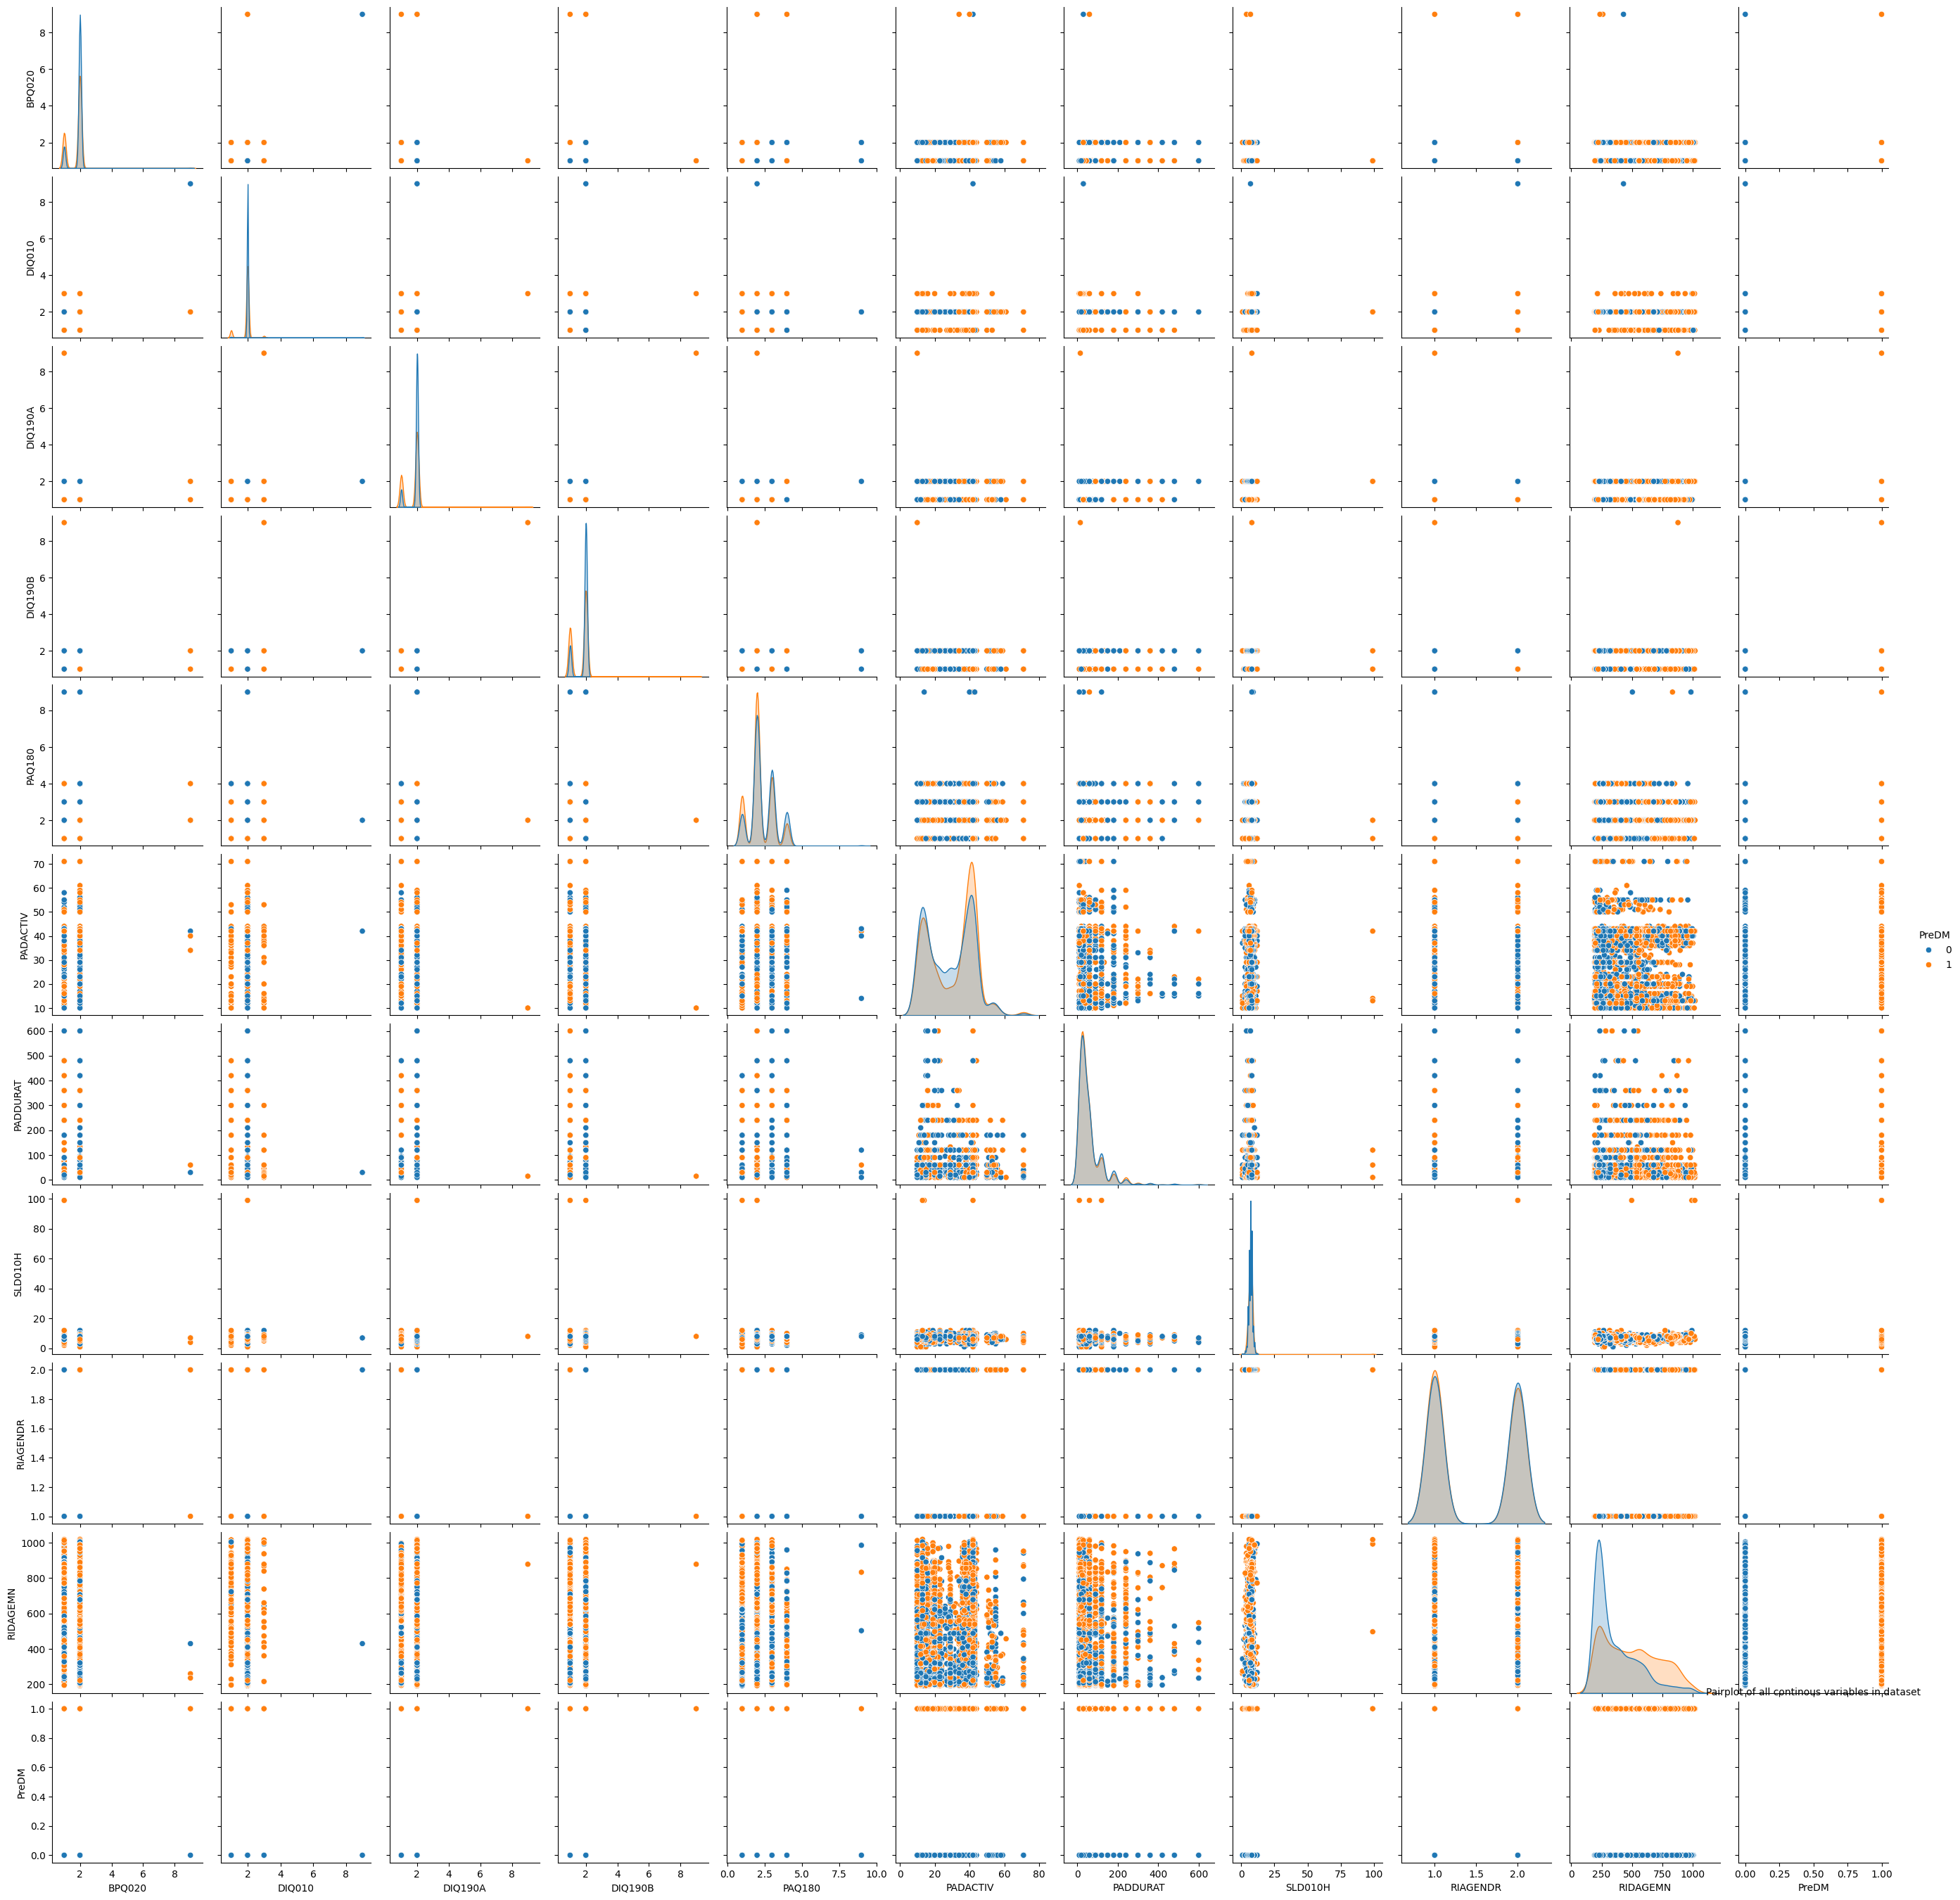

In [101]:
## visualization: pairplot
import seaborn as sns
import matplotlib.pyplot as plt

def continous_main():
    labeled_selected_features = pd.read_csv('selected_features_labeled_final.csv', sep='\t')
    continous_graph(labeled_selected_features)

def continous_graph(labeled_selected_features):
    continuous_vars = [col for col in labeled_selected_features.columns 
                       if labeled_selected_features[col].dtype in ['float64', 'int64']]
    #remove SEQN value
    del continuous_vars[0]
    
    plt.figure(figsize=(10,6))

    sns.pairplot(labeled_selected_features, vars=continuous_vars, hue='PreDM', diag_kind='kde')
    plt.title("Pairplot of all continous variables in dataset", fontsize=10)
    #print("test line")
    plt.savefig("final_visualizations/pairplot_before_division.png") 
                        # before division of correct/wrong groups, confusion matrix
    plt.show()  

if __name__ == "__main__":
    continous_main()